# Housing Price and Weekly Rent Prediction Final Report
#### Group: ITEC _ Pract _ 03(Tue 7pm) _ Group B
#### Group Members:
* Abdul Sattar Mohammed - 45830541
* Jan Arvin Lapuz - 45758891
* Jerome Roosan - 45999589
* Le Van Nguyen - 45817006

## Objective
A property's sale price or its weekly rent vary for different areas across the region. The focus of our project are the properties on the New South Wales (NSW) region and the unit of analysis is the Local Government Area (LGA) defined by the Government of NSW. There are many factors affecting the movement of house price and weekly rent and we will direct our attention to datasets that are collected using the traditional method (census and transportation modes) and remote sensing (nighttime lights). At the end of the analysis, we aim to answer the following questions:
* How do the demographic characteristics, transportation modes and nighttime lights affect house prices and weekly rent?
* What are the best features that help predict the house price and weekly rent?


## Data Collection
The analysis makes use of the following datasets:
1. Census
    * The census dataset was extracted from the Australian Bureau of Statistics' Census General Data Community Profile Data Packs for the LGAs of NSW. It contains aggregated population information from 2016 for each LGA such as age groups, income brackets and educational attainment. The census datapacks also comes with a shapefile with the boundaries of each LGA in NSW.


2. Transportation Points
    * The transportation points were accessed and extracted through the Transport for NSW (TfNSW) Open Data API for Public Transport Timetables which consists of information on different transportation stops across the region with the corresponding longitude and latitude locations. There were no historical transportation points in the Transport for NSW Open Data API for Public Transport Timetables as they are updated in real-time.


3. Nighttime Lights
    * The nighttime lights dataset is downloaded from the Earth Observation Group at the National Oceanic and Athmospheric Administration who manages the satellite that captures and processes the lights at night for the entire surface of Earth. The dataset are raster graphic files which are stored in Tagged Image File Format. We downloaded the raster graphic file closest census year (June 2017) and house rent and weekly rent quarterly reports.


4. House Sales and Weekly Rent
    * The house sales and weekly rent datasets were downloaded from the Department of Communities and Justice (formerly the Department of Family and Community Services). The dataset contains quarterly reports of house sales broken down by LGA and dwelling type and quarterly reports of weekly rent by LGA, number of bedrooms and dwelling type. Again, we downloaded dataset for house sales (June 2017) and weekly rent (September 2017) closest to the census year.
    


## Data Processing and Preparation
### Census
We start by processing the census dataset. The census data pack contains an enormous amount of data with a total more 15,500 different LGA characteristics. We trimmed down this dataset so that we are left with only those features we think that are important in predicting the house sales price and weekly rent and came up with the following:
* Age distribution
* Household size
* Weekly income
* Educational attainment
* Country of origin
* Marital status

The compilation was done on two separate Jupyter notebooks named:
* `Data Preprocessing_Jerome_Census Variables.ipynb` with the output file saved in `Data/census2016/census2016_file01.csv`
* `Data Preprocessing_Jan_Census Variables.ipynb` with the output file saved in `Data/census2016/census2016_file02.csv`

Since almost all of the features are count of persons on each LGA, we performed several calculations to convert them into percentages since count will depend on how large the population is on an LGA.

### Transportation
We downloaded the transportation dataset from the TfNSW API for Public Transport by creating an account and applying for an API key that accesses the API. The API generates a text file containing all the transportation stops (bus stops, train stations, wharfs) with their location in the form of geographic coordinates. The file does not specify if a data point is a bus stop, train stop or wharf. Manual tagging was performed to classify each of the stops as either bus stops, coach stops, light rail, or train stations, wharfs.

In order to count the number of stops per LGA, we used a free geographic interface system called Quantum GIS (QGIS) with the MMQGIS add-on to convert the text file into a map of points which is a visual representation of the stops on the surface of the Earth.

We load the output of the QGIS process in the notebook and overlay the census shapefile containing the boundaries of each LGA to count the number of transportation stops that fall inside the boundaries of each of the LGAs. We also created new variables to combine all bus and coach stops, trains and light rails, and count of all transportation stops. The `geopandas` package was employed to perform the geoprocessing task while the `pandas` package was used to create the new variables.

**Note**: Please download the dBASE file for the Transportation, `transpo_stations.dbf.zip`, (~100MB unzipped) from Google Drive, save and unzip on `Data/transportation/` folder (http://bit.ly/32cTdXX).

<img src = "Files/transpo_stops_nsw.png" width = "500">

In [1]:
import pandas as pd
import geopandas as gpd

nsw_lga_bound = gpd.read_file('Data/shapefiles/NSW_LGA_2016.shp')
transpo_points = gpd.read_file('Data/transportation/transpo_stations.shp')
dfsjoin = gpd.sjoin(nsw_lga_bound, transpo_points)
dfpivot = pd.pivot_table(dfsjoin, index = 'LGA_CODE', columns = 'transporta', aggfunc = len)

lga_transpo = dfpivot['stop_id'].reset_index().fillna(0)
lga_transpo['all_bus_stops'] = lga_transpo.bus_stop + lga_transpo.coach_stop
lga_transpo['all_train_stations'] = lga_transpo.light_rail + lga_transpo.train_station
lga_transpo['all_transpo'] = lga_transpo.all_bus_stops + lga_transpo.all_train_stations
lga_transpo.head()

transporta,LGA_CODE,bus_stop,coach_stop,light_rail,train_station,wharf,all_bus_stops,all_train_stations,all_transpo
0,LGA10050,90.0,0.0,0.0,1.0,0.0,90.0,1.0,91.0
1,LGA10130,17.0,3.0,0.0,1.0,0.0,20.0,1.0,21.0
2,LGA10250,60.0,7.0,0.0,0.0,0.0,67.0,0.0,67.0
3,LGA10300,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0
4,LGA10470,136.0,6.0,0.0,1.0,0.0,142.0,1.0,143.0


### Nighttime Lights
The amount of light observed from space is captured and processed on a daily basis by the National Oceanic and Atmospheric Administration. Their observations are averaged on all cloud-free days which are published as monthly and annual composites. The files are made available to the public in the form of raster graphic files stored as Tagged Image File Format. We can think of the image as a matrix containing the average luminosity on each pixel which is approximately about 500 $m^2$. This is available for almost all surface of the Earth. We download the raster file for June 2017, which is the closest to the census year and the house sales and weekly rent reports.

**Note**: Please download the Australian nighttime lights files, `AUS_nightlights_201706.tif.zip` and `AUS_nightlights_201904.tif.zip` (~1.2GB unzipped) from Google Drive, save and unzip it on `Data/nightlights/` folder (http://bit.ly/32cTdXX).

Below is a snapshot (not the data used in analysis) of Australia nightlights:

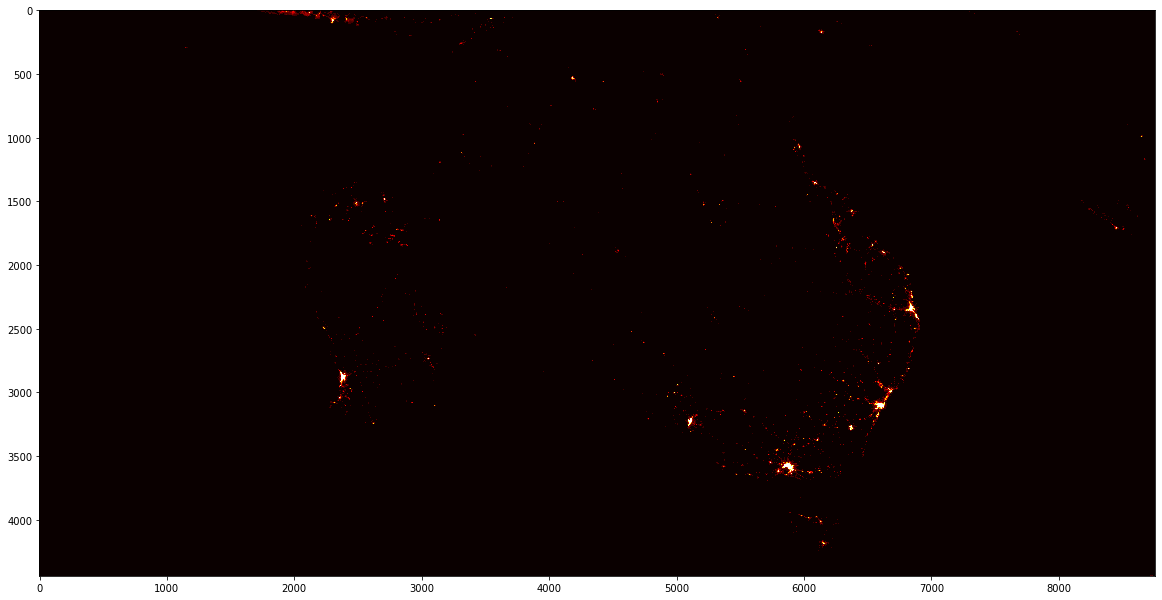

In [2]:
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

nightlight_file = rasterio.open('Files/australia_ntl_snapshot.tif')
nightlights = nightlight_file.read(1)
plt.figure(figsize = (20, 15))
plt.imshow(nightlights, cmap = 'hot')

Similar to the processing of transportation dataset, we use the census shapefile and overlay it to the nighttime light raster file and compute summary statistics of the pixel values that fall inside each LGA's boundaries. For this task, we use the `zonal_stats` function from the `rasterstats` package and we calculate for the count of pixels, minimum and maximum nighttime light values, and the sum and average of all nighttime lights contained in the boundaries of each LGA. We perform this task for both the 2017 and 2019 raster graphic files.

<img src = "Files/australia_ntl_2017.png" width = "500">

In [3]:
from rasterstats import zonal_stats

stats_lga_17 = zonal_stats(nsw_lga_bound, 'Data/nightlights/AUS_nightlights_201706.tif', nodata =  0,
                           stats = 'count min mean max sum', geojson_out = True)

lga_ntl_17 = pd.DataFrame(columns = ['LGA_CODE', 'LGA_CODE16', 'LGA_NAME', 'STATE_CODE', 'STATE_NAME', 'AREA_SQKM',
                                     'count', 'min', 'mean', 'max', 'sum'])
for i in range(len(stats_lga_17)):
        orderedDictList = stats_lga_17[i]['properties']
        dummy = pd.DataFrame(orderedDictList, columns = orderedDictList.keys(), index = [0])
        lga_ntl_17 = lga_ntl_17.append(dummy, ignore_index = True, sort = False)
lga_ntl_17 = lga_ntl_17[['LGA_CODE', 'AREA_SQKM', 'count', 'min', 'mean', 'max', 'sum']]
lga_ntl_17.columns = ['LGA_CODE', 'land_area', 'ntl17_count', 'ntl17_min', 'ntl17_mean', 'ntl17_max', 'ntl17_sum']
lga_ntl_17.head()

,LGA_CODE,land_area,ntl17_count,ntl17_min,ntl17_mean,ntl17_max,ntl17_sum
0,LGA10050,305.9459,1766,0.14,2.375328,59.139999,4194.830078
1,LGA10130,8620.6990,46613,-0.01,0.210830,34.509998,9827.399414
2,LGA10250,484.9389,2576,0.09,0.619946,20.860001,1596.979980
3,LGA10300,21690.6753,121835,0.07,0.201670,10.460000,24570.441406
4,LGA10470,3817.8646,21325,0.06,0.334099,48.869999,7124.670410


In [4]:
stats_lga_19 = zonal_stats(nsw_lga_bound, 'Data/nightlights/AUS_nightlights_201904.tif', nodata =  0,
                           stats = 'count min mean max sum', geojson_out = True)

lga_ntl_19 = pd.DataFrame(columns = ['LGA_CODE', 'LGA_CODE16', 'LGA_NAME', 'STATE_CODE', 'STATE_NAME', 'AREA_SQKM',
                                     'count', 'min', 'mean', 'max', 'sum'])
for i in range(len(stats_lga_19)):
        orderedDictList = stats_lga_19[i]['properties']
        dummy = pd.DataFrame(orderedDictList, columns = orderedDictList.keys(), index = [0])
        lga_ntl_19 = lga_ntl_19.append(dummy, ignore_index = True, sort = False)
lga_ntl_19 = lga_ntl_19[['LGA_CODE', 'count', 'min', 'mean', 'max', 'sum']]
lga_ntl_19.columns = ['LGA_CODE', 'ntl19_count', 'ntl19_min', 'ntl19_mean', 'ntl19_max', 'ntl19_sum']
lga_ntl_19.head()

,LGA_CODE,ntl19_count,ntl19_min,ntl19_mean,ntl19_max,ntl19_sum
0,LGA10050,1766,0.20,2.501557,56.820000,4417.750000
1,LGA10130,46614,0.05,0.234065,41.060001,10910.721680
2,LGA10250,2576,0.13,0.650873,23.889999,1676.650024
3,LGA10300,121835,0.10,0.259825,10.840000,31655.767578
4,LGA10470,21325,0.08,0.371763,46.009998,7927.839844


In [5]:
lga_ntl = lga_ntl_17.merge(lga_ntl_19, on = 'LGA_CODE', how = 'outer')
lga_ntl.head()

,LGA_CODE,land_area,ntl17_count,ntl17_min,ntl17_mean,ntl17_max,ntl17_sum,ntl19_count,ntl19_min,ntl19_mean,ntl19_max,ntl19_sum
0,LGA10050,305.9459,1766,0.14,2.375328,59.139999,4194.830078,1766,0.20,2.501557,56.820000,4417.750000
1,LGA10130,8620.6990,46613,-0.01,0.210830,34.509998,9827.399414,46614,0.05,0.234065,41.060001,10910.721680
2,LGA10250,484.9389,2576,0.09,0.619946,20.860001,1596.979980,2576,0.13,0.650873,23.889999,1676.650024
3,LGA10300,21690.6753,121835,0.07,0.201670,10.460000,24570.441406,121835,0.10,0.259825,10.840000,31655.767578
4,LGA10470,3817.8646,21325,0.06,0.334099,48.869999,7124.670410,21325,0.08,0.371763,46.009998,7927.839844


The transportation and nighttime lights datasets are merged as one `.csv` file and saved as `transpo_ntl.csv`

### House Sales and Weekly Rent
The Department of Communities and Justice releases quarterly reports on house sales and weekly rent per LGA of NSW. We download the report that is closest to the census year to minimise the time discrepancy between the datasets. Upon inspection, the LGAs (codes) only started coinciding with census names on the June 2017 house sales report and the September 2017 weekly rent report.

We combine datasets using the LGA codes and since the house sales and weekly rent reports don't include this information, we created a master file of LGA code and its corresponding LGA name (`Data/lga_code_and_names.csv`). We created functions that reads the house sales and weekly rent reports and transforms them into datasets that we are able to work comfortably with. The house sales report is converted into two datasets: (1) overall and (2) by dwelling type. The weekly rent report is converted into three datasets: (1) overall, (2) by bedroom number and (3) by dwelling type.

The Jupyter notebook that processes the house sales and weekly rent is saved as `Jan_Data Preprocessing_Rent and Sales Dataset by LGA.ipynb` with the following output files written in `.csv` format:

* **House Sales**:
    * `house_sales_0617_overall_mean.csv`
    * `house_sales_0617_dwelling_mean.csv`
    * `house_sales_0617_overall_median.csv`
    * `house_sales_0617_dwelling_median.csv`


* **Weekly Rent**:
    * `house_rent_0917_overall.csv`
    * `house_rent_0917_bedroom.csv`
    * `house_rent_0917_dwelling.csv`
    
### Merging All the Datasets
The census, transportation, nighttime lights, house sales and weekly rent datasets are now ready to be merged as one final dataset for the analysis. All the datasets contain the `LGA_CODE` which is going to be the merging criteria. This task is performed on the `Van_Data Preprocessing_Merging All Datasets.ipynb` where all the datasets from various sources are loaded and combined using `LGA_CODE`. The final dataset for the 2017 house sales and weekly rent dataset is saved as `Data/final17_dataset.csv`. The details for each variable is described in the `Data/final17_dataset_Data Description.xlsx`.

## Data Analysis and Modelling
In this section we explore how various characteristics of an LGA are associated with house sales and weekly rent. We employ two machine learning methods to predict each response variables: linear regression, which we will treat as the baseline model, and decision tree regression. We will compare the results of each model and recommend which algorithm performs better in predicting house sales and weekly rent.

### Weekly Rent
The weekly rent dataset contains the overall median weekly rent, median weekly rent by bedroom number and weekly median rent by dwelling type. We conduct the analysis by creating a model for each of the three set of data for median weekly rent.

#### Predicting Median Weekly Rent using Linear Regression
The details of the analysis for weekly median rent is contained in the `Data Analysis_Jan_Rent Prediction Using Linear Regression.ipynb`. Below is a summary of the analysis done in the notebook:
* Descriptive analysis of the median weekly rent dataset and examining its relationship with the predictor variables.
* Predictor variables are trimmed down to those that have a high correlation with median weekly rent. For variables that belong to one category and have high correlation with median weekly rent, e.g. percentage of people who are 14 years old and below (`pct_age_14below`) percentage of people who are between 15 years old and 64 years old (`pct_age_15_64`), we only choose one representation for the variable.
* We create models from the different combinations of variables:
    * Census variables only
    * Transportation variables only
    * Nighttime Lights variables only
    * Transportation and Nighttime Lights
    * All Variables
* We build linear regression model this way for the three set of weekly rent data with the same end result. The model with best predictive power for all three cases is the census only model while the model with the least predictive power is the nighttime lights model.
* Recursive feature elimination was also performed on the all three dataset and it turns out the most important predictor is the percentage of person who have completed Year 10 and above (`pct_educ_yr10above`). This is then followed by count of bus stops per land area (`bstop_per_land_area`).
* The conclusion is: while the most of the important predictors comes from the census, transportation is also a relevant predictor of weekly rent. This means that the population characteristics of an LGA has an effect on the weekly rent for that LGA, accessibility also plays a role in the weekly rent of an LGA.

#### Predicting Median Weekly Rent using Decision Tree Regression
The decision tree regression analysis for weekly median rent is contained in the `Data Analysis_Van_Rent Prediction Using Decision Tree Regression.ipynb`. Below is a summary of the analysis done in the notebook:
* The steps performed to build the decision tree regression model for the three set of weekly rent variables in the dataset:
    * Run a grid search to learn the best parameter for the maximum depth of the tree.
    * Fit the decision tree model on the training dataset and compute the $R^2$.
    * Predict the weekly rent for the testing dataset and compute the $R^2$.
    * Report the model assessment metrics and choose the best set of predictors.
* The analysis is conducted iteratively using different combinations of variables:
    * Census variables only
    * Transportation variables only
    * Nighttime Lights variables only
    * Transportation and Nighttime Lights
    * All Variables
* Using all variables in the decision tree gives a very high $R^2$ both training and testing datasets. $R^2$ is also high for the model including all census variables.
* The count of train stations per land area (`tstation_per_land_area`) does not provide good predictive power for weekly rent while the count of bus station
* The nighttime lights variable provides a good predictive power as evidenced by the $R^2$ from the training and testing datasets.
* Generally, decision tree models perform better than linear regression models if we are looking purely at $R^2$ only. Root mean squared errors (RMSE) don't seem to coincide with the training and testing datasets.

#### Predicting Median House Sales using Linear Regression
The details of the analysis for weekly median rent is contained in the `Data Analysis_Jerome_Sales Prediction Using Linear Regression.ipynb`. Below is a summary of the analysis done in the notebook:
* The mean of house sales contains a number of outliers, hence, the median house sales was used in the analysis.
* The median house sales is skewed to the right with most of the dataset falling below 500 (in /$'000's).
* We simulate the various census variables and fit a linear regression model for each. Census variables are still the best predictors among the three set of features in our dataset. Income provides the highest predictive power in the model.
* When predicting house sales per dwelling type, the same set of census variables appear to have a significant effect on house sales. Transportation variables are also coming up as one of the important variables in the prediction.

#### Predicting Median House Sales using Decision Tree Regression
The details of the analysis for weekly median rent is contained in the `Data Analysis_Abdul_Sales Prediction Using Decision Tree.ipynb` and `Data Analysis_Van_Sales Prediction Using Decision Tree.ipynb`. Below is a summary of the analysis done in the notebook:
* Overfitting is very evident in all the models created for overall house sales and house sales by dwelling type. The $R^2$ for the training datasets can go as high as 1.00 but the testing datasets have considerably lower $R^2$.
* Grid search was conducted for each of the models to check the best value for the maximum depth of the tree. This might have been the cause for the overfitting issue of the models.
* Similar to weekly rent decision tree regression models, RMSE values for training data is very low while the RMSE values for testing dataset are considerably higher.


## Summary and Conclusion
We explored different population characteristics, transportation data and spatial datasets per LGA and examined their relationship against house sales and weekly rent. Census variables are the best predictors among the three sets of features in both the linear regression and decision tree regression. Transportation variables also play a role in predicting house sales and weekly rent which means that the degree of accessibility within the LGA affects the house prices and weekly rent for that area.

While the nighttime lights only provide a decent level of predictive power by itself, an advantage for this spatial dataset is its availability. The nighttime lights data is produced on a monthly basis and available for almost all surface of the Earth.

In terms of the modelling techniques, decision trees are not the most appropriate algorithm as it tends to overfit the data. Linear regression, on the other hand, provides more consistent model assessment metrics and gives a very high $R^2$ with census variables as predictors.

A possible extension of this project is to apply the data processing and analysis methods per post code. House sales, weekly rent, population characteristics, transportation data and nighttime lights are all available by post codes or can easily be extracted using the methodology discussed in the project. Further exploration can be performed to see if the best features in predicting house sales and weekly rent identified in this analysis of LGAs also apply for post codes.

## Data Sources
* Census Data Packs and Shapefiles (https://datapacks.censusdata.abs.gov.au/datapacks/)
* Transportation API (https://opendata.transport.nsw.gov.au/node/334/exploreapi#!/gtfs/GetSydPubTransGTFS)
* VIIRS Nighttime Lights (https://ngdc.noaa.gov/eog/viirs/download_dnb_composites.html)
* House Sales and Weekly Rent (https://www.facs.nsw.gov.au/resources/statistics/rent-and-sales/dashboard)